In [140]:
import os
import sys
import glob
import numpy as np
import pandas as pd
from IPython.display import display
import time 
import tracker
import seaborn as sns
from matplotlib import pyplot as plt
latest_date = tracker.processing_dates[-1]
os.chdir('/mnt/BioAdHoc/Groups/vd-ay/hichip-db-loop-calling/')
pd.set_option('display.max_rows', 1000)
pd.set_option('display.max_columns', 1000)

In [141]:
# setting input and output with jupyter notebook in context 
if 'ipykernel_launcher.py' in sys.argv[0]:
    input_fn = 'results/samplesheets/hicpro/{}.hicpro.samplesheet.with_header.tsv'.format(latest_date) 
    split_fastqs = 'results/samplesheets/fastq/{}.fastq.post-check.split_fastqs.with_header.tsv'.format(latest_date)
    hicpro_fn = 'results/samplesheets/fastq/{}.fastq.post-check.run_hicpro'.format(latest_date)
else:
    input_fn = sys.argv[1]
    split_fastqs = sys.argv[2]
    hicpro_fn = sys.argv[3]

## Helper Functions

In [142]:
def get_log(x, mode='index'):
    
    if mode == 'index':
        logs = glob.glob('results/fastqs/raw/logs/download_srr_fastqs.*-{}'.format(x))
        
    elif mode == 'path':
        info = x.split('/')
        sample_name = info[3]
        srr_id  = info[4].split('.')[0].split('_')[0]
        index = df.loc[(df[0] == sample_name) & (df[3] == srr_id)].iloc[0].name
        logs = glob.glob('results/fastqs/raw/logs/download_srr_fastqs.*-{}'.format(index))
        
    else:
        return('Try again.')
    
    return(logs)

def list_to_str(l, sep=' '):
    l = [str(x) for x in l]
    return(sep.join(l))

In [143]:
def read_hicpro_step2_log(log):
    
    """
    Read the log and extract status information including
    the sample_name, srr_id, status (as indicated by the end message),
    and the download status (as indicate by the "reads written" message).
    """
        
    # initializing the statuses to 0
    hicpro_status = 0

    if os.path.exists(log):
        with open(log, errors='ignore') as fr:
            for line in fr:
                info = line.strip()
                if 'Run ICE Normalization ...' in info:
                    hicpro_status = 1
    return(hicpro_status)

In [144]:
def long_to_short_index_list(serial_list):
    
    if len(serial_list) == 0:
        serial_list_short = []
        
    elif len(serial_list) == 1:
        serial_list_short = [str(serial_list[0])]
        
    else:
        small_num = serial_list[0]
        serial_list_short = []
        for i in range(1, len(serial_list)):

            prev_num = serial_list[i -1]
            next_num = serial_list[i]

            if (prev_num + 1) != next_num:

                if small_num == prev_num:
                    curr_range = '{}'.format(small_num)
                    serial_list_short.append(curr_range)
                    small_num = next_num

                else:
                    curr_range = '{}-{}'.format(small_num, prev_num)
                    serial_list_short.append(curr_range)
                    small_num = next_num

        if small_num == next_num:
            curr_range = '{}'.format(small_num,)
            serial_list_short.append(curr_range)
        else:
            curr_range = '{}-{}'.format(small_num, next_num)
            serial_list_short.append(curr_range)

    return(serial_list_short)

## Check HiCPro Main Logs

In [145]:
# load the samplesheet table
df = pd.read_table(input_fn)
df['sample_index'] = df.index + 1

In [146]:
log_data = []
for i, sr in df.iterrows():
    
    s1_log = glob.glob('results/hicpro/{}/HiCpro_s1_.e*'.format(sr.std_sample_name))
    s2_log = glob.glob('results/hicpro/{}/HiCpro_s2_.e*'.format(sr.std_sample_name))
    
    # check if s1 steps have started
    if len(s1_log) > 0:
        hicpro_start_status = 1
    else:
        hicpro_start_status = 0
    
    # check if s2 steps have ended 
    if len(s2_log) == 1:
        s2_log = s2_log[0]
        hicpro_end_status = read_hicpro_step2_log(s2_log)
    else:
        hicpro_end_status = 0 
        
    log_data.append([sr.std_sample_name, hicpro_start_status, hicpro_end_status])

log_df = pd.DataFrame(log_data)
log_df.columns = ['std_sample_name', 'hicpro_start_status', 'hicpro_ended_status']    

In [147]:
# merge the log information
df = df.merge(log_df, how='left', on=['std_sample_name'], indicator='merge')

In [148]:
df.head()

,std_sample_name,gse_id,organism,bio_rep,antibody_target,restriction_enzyme,sample_name,sample_index,hicpro_start_status,hicpro_ended_status,merge
0,mES_25m_cells.GSE101498.Mus_Musculus.H3K27ac.b1,GSE101498,Mus_Musculus,1,H3K27ac,MboI,mES_25m_cells,1,1,1,both
1,mES_25m_cells.GSE101498.Mus_Musculus.H3K27ac.b2,GSE101498,Mus_Musculus,2,H3K27ac,MboI,mES_25m_cells,2,1,1,both
2,mES_500k_cells.GSE101498.Mus_Musculus.H3K27ac.b1,GSE101498,Mus_Musculus,1,H3K27ac,MboI,mES_500k_cells,3,1,1,both
3,mES_500k_cells.GSE101498.Mus_Musculus.H3K27ac.b2,GSE101498,Mus_Musculus,2,H3K27ac,MboI,mES_500k_cells,4,1,1,both
4,mES_100k_cells.GSE101498.Mus_Musculus.H3K27ac.b1,GSE101498,Mus_Musculus,1,H3K27ac,MboI,mES_100k_cells,5,1,1,both


#### add the split data

In [149]:
split_df = pd.read_table(split_fastqs)
df = df.merge(split_df[['std_sample_name', 'gse_id', 'split_fastqs_end_status']], on=['std_sample_name', 'gse_id'])

In [150]:
df

,std_sample_name,gse_id,organism,bio_rep,antibody_target,restriction_enzyme,sample_name,sample_index,hicpro_start_status,hicpro_ended_status,merge,split_fastqs_end_status
0,mES_25m_cells.GSE101498.Mus_Musculus.H3K27ac.b1,GSE101498,Mus_Musculus,1,H3K27ac,MboI,mES_25m_cells,1,1,1,both,1
1,mES_25m_cells.GSE101498.Mus_Musculus.H3K27ac.b2,GSE101498,Mus_Musculus,2,H3K27ac,MboI,mES_25m_cells,2,1,1,both,1
2,mES_500k_cells.GSE101498.Mus_Musculus.H3K27ac.b1,GSE101498,Mus_Musculus,1,H3K27ac,MboI,mES_500k_cells,3,1,1,both,1
3,mES_500k_cells.GSE101498.Mus_Musculus.H3K27ac.b2,GSE101498,Mus_Musculus,2,H3K27ac,MboI,mES_500k_cells,4,1,1,both,1
4,mES_100k_cells.GSE101498.Mus_Musculus.H3K27ac.b1,GSE101498,Mus_Musculus,1,H3K27ac,MboI,mES_100k_cells,5,1,1,both,1
5,mES_100k_cells.GSE101498.Mus_Musculus.H3K27ac.b2,GSE101498,Mus_Musculus,2,H3K27ac,MboI,mES_100k_cells,6,1,1,both,1
6,mES_50k_cells.GSE101498.Mus_Musculus.H3K27ac.b1,GSE101498,Mus_Musculus,1,H3K27ac,MboI,mES_50k_cells,7,1,1,both,1
7,mES_50k_cells.GSE101498.Mus_Musculus.H3K27ac.b2,GSE101498,Mus_Musculus,2,H3K27ac,MboI,mES_50k_cells,8,1,1,both,1
8,GM.GSE101498.Homo_Sapiens.H3K27ac.b1,GSE101498,Homo_Sapiens,1,H3K27ac,MboI,GM,9,1,1,both,1
9,GM.GSE101498.Homo_Sapiens.H3K27ac.b2,GSE101498,Homo_Sapiens,2,H3K27ac,MboI,GM,10,1,1,both,1


## Identifying problem samples

In [151]:
problems = (df.split_fastqs_end_status == 1) & (df.hicpro_start_status == 0)
problems_df = df.loc[problems,:]
problems_df

,std_sample_name,gse_id,organism,bio_rep,antibody_target,restriction_enzyme,sample_name,sample_index,hicpro_start_status,hicpro_ended_status,merge,split_fastqs_end_status
35,HK2.GSE147646.Homo_Sapiens.H3K27ac.b1,GSE147646,Homo_Sapiens,1,H3K27ac,MboI,HK2,36,0,0,both,1


## Re-run problematic/ready samples

In [152]:
# convert not run serial IDs to ranges/short format
rerun_indexes = sorted(problems_df.sample_index.tolist())
rerun_indexes_sort = long_to_short_index_list(rerun_indexes)

In [153]:
rerun_indexes_sort

['36']

In [154]:
# generate a string version of not_run
final_rerun = ','.join(rerun_indexes_sort)
final_rerun = 'qsub -t {} workflow/scripts/hicpro/run_hicpro.qarray.sh'.format(final_rerun)

In [155]:
print(final_rerun)

qsub -t 36 workflow/scripts/hicpro/run_hicpro.qarray.sh


In [156]:
bash_indexes = ' '.join([str(x) for x in rerun_indexes])
bash_rerun = 'job_ids="{}"\n'.format(bash_indexes)
bash_rerun += 'for i in $job_ids; do bash workflow/scripts/hicpro/run_hicpro.qarray.sh $i; done'

In [157]:
print(bash_rerun)

job_ids="36"
for i in $job_ids; do bash workflow/scripts/hicpro/run_hicpro.qarray.sh $i; done


In [158]:
problem_samples = problems_df.std_sample_name.values.tolist()
problem_samples = ' '.join(problem_samples)
problem_samples

'HK2.GSE147646.Homo_Sapiens.H3K27ac.b1'

In [159]:
len(rerun_indexes)

1

## Notes on problems

**Updates 2022.04.03**
 - HK2.GSE147646.Homo_Sapiens.H3K27ac.b1 - splitting didn't work correctly. Missing 05_*
 - HARA.GSE147854.Homo_Sapiens.H3K27ac.b1 - now rerunning, fixed dependency as well
 - lgs102943.GSE116193.Homo_Sapiens.H3K27ac.b1 - now rerunning, had to fix dependency

Putting the whole list for 2022.04.03

- HK2.GSE147646.Homo_Sapiens.H3K27ac.b1
- HARA.GSE147854.Homo_Sapiens.H3K27ac.b1
- lgs102943.GSE116193.Homo_Sapiens.H3K27ac.b1
- lgs301315.GSE116193.Homo_Sapiens.CTCF.b1
- lgs102943.GSE116193.Homo_Sapiens.CTCF.b1
- lgs301315.GSE116193.Homo_Sapiens.H3K27ac.b1
- lgs102580.GSE116193.Homo_Sapiens.H3K27ac.b1
- lgs101645.GSE116193.Homo_Sapiens.H3K27ac.b1
- EBNA2_Plus_Ramos.GSE179755.Homo_Sapiens.H3K27ac.b1
- Naive_Tcells.GSE101498.Homo_Sapiens.H3K27ac.b1
- mES_50k_cells.GSE101498.Mus_Musculus.H3K27ac.b1
- mES_500k_cells.GSE101498.Mus_Musculus.H3K27ac.b1
- Naive_Tcells.GSE101498.Homo_Sapiens.H3K27ac.b2
- Treg.GSE101498.Homo_Sapiens.H3K27ac.b1
- lgs301283.GSE116193.Homo_Sapiens.CTCF.b1

# Check HiCPro Statistics Logs for Mapping and Valid Pair Information

        ├── H9.GSE105028.Homo_Sapiens.Rad21.b1_allValidPairs.mergestat
        ├── H9.GSE105028.Homo_Sapiens.Rad21.b1.mpairstat
        ├── H9.GSE105028.Homo_Sapiens.Rad21.b1.mRSsta

In [160]:
def read_hicpro_stats_log(log):
    log_data = {}
    with open(log) as fr:
        for line in fr:
            if line.startswith('#'):
                continue
            else:
                info = line.strip().split()
                log_data[info[0]] = int(info[1])
    return(log_data)

#### process the mpairstat files

In [161]:
mpairstat_data = []
tpl = 'results/hicpro/{std_sample_name}/hic_results/stats/{std_sample_name}/{std_sample_name}.mpairstat'
glob_str = tpl.format(std_sample_name='*')
for fn in glob.glob(glob_str):
    std_sample_name = fn.split('/')[2]
    mpairstat = read_hicpro_stats_log(fn)
    mpairstat['std_sample_name'] = std_sample_name
    mpairstat_data.append(mpairstat)
mpairstat_df = pd.DataFrame.from_dict(mpairstat_data)

In [162]:
mpairstat_df.head()

,Total_pairs_processed,Unmapped_pairs,Low_qual_pairs,Unique_paired_alignments,Multiple_pairs_alignments,Pairs_with_singleton,Low_qual_singleton,Unique_singleton_alignments,Multiple_singleton_alignments,Reported_pairs,std_sample_name
0,88687267,7356114,22188261,54486749,0,4656143,0,0,0,54486749,HT55.GSE147854.Homo_Sapiens.H3K27ac.b1
1,42179029,1059374,13116390,25579060,0,2424205,0,0,0,25579060,Ramos.GSE179755.Homo_Sapiens.H3K27ac.b1
2,56100419,1082647,19409942,27220820,0,8387010,0,0,0,27220820,H9-siNIPBL-HS.GSE105028.Homo_Sapiens.CTCF.b1
3,92821305,1549281,26370704,58668864,0,6232456,0,0,0,58668864,Th17.GSE101498.Homo_Sapiens.H3K27ac.b1
4,114611937,110087000,46997,2472,0,4475468,0,0,0,2472,Villus-Hnf4DKO.GSE148691.Mus_Musculus.H3K4me3.b1


#### process the mRSstat files

In [163]:
mRSstat_data = []
tpl = 'results/hicpro/{std_sample_name}/hic_results/stats/{std_sample_name}/{std_sample_name}.mRSstat'
glob_str = tpl.format(std_sample_name='*')
for fn in glob.glob(glob_str):
    std_sample_name = fn.split('/')[2]
    mRSstat = read_hicpro_stats_log(fn)
    mRSstat['std_sample_name'] = std_sample_name
    mRSstat_data.append(mRSstat)
mRSstat_df = pd.DataFrame.from_dict(mRSstat_data)

In [164]:
mRSstat_df.head()

,Valid_interaction_pairs,Valid_interaction_pairs_FF,Valid_interaction_pairs_RR,Valid_interaction_pairs_RF,Valid_interaction_pairs_FR,Dangling_end_pairs,Religation_pairs,Self_Cycle_pairs,Single-end_pairs,Filtered_pairs,Dumped_pairs,std_sample_name
0,21215608,4641464,4644784,5310214,6619146,21763210,10568582,935997,0,0,3352,HT55.GSE147854.Homo_Sapiens.H3K27ac.b1
1,17915546,4426978,4435366,4423709,4629493,6327668,1275182,59864,0,0,800,Ramos.GSE179755.Homo_Sapiens.H3K27ac.b1
2,12093604,2767517,2758002,2549571,4018514,10568412,4009473,14968,0,0,534363,H9-siNIPBL-HS.GSE105028.Homo_Sapiens.CTCF.b1
3,42525103,10242624,10269169,10872246,11141064,10722367,4554771,865018,0,0,1605,Th17.GSE101498.Homo_Sapiens.H3K27ac.b1
4,1985,443,546,493,503,322,141,15,0,0,9,Villus-Hnf4DKO.GSE148691.Mus_Musculus.H3K4me3.b1


#### process the mergestat files

In [165]:
mergestat_data = []
tpl = 'results/hicpro/{std_sample_name}/hic_results/stats/{std_sample_name}/{std_sample_name}_allValidPairs.mergestat'
glob_str = tpl.format(std_sample_name='*')
for fn in glob.glob(glob_str):
    std_sample_name = fn.split('/')[2]
    mergestat = read_hicpro_stats_log(fn)
    mergestat['std_sample_name'] = std_sample_name
    mergestat_data.append(mergestat)
mergestat_df = pd.DataFrame.from_dict(mergestat_data)

In [166]:
mergestat_df.head()

,valid_interaction,valid_interaction_rmdup,trans_interaction,cis_interaction,cis_shortRange,cis_longRange,std_sample_name
0,21215608,19989419,2394823,17594596,8878873,8715723,HT55.GSE147854.Homo_Sapiens.H3K27ac.b1
1,17915546,16708096,3443181,13264915,2891308,10373607,Ramos.GSE179755.Homo_Sapiens.H3K27ac.b1
2,12093604,4305620,674711,3630909,1709156,1921753,H9-siNIPBL-HS.GSE105028.Homo_Sapiens.CTCF.b1
3,42525103,38423564,10622817,27800747,9805885,17994862,Th17.GSE101498.Homo_Sapiens.H3K27ac.b1
4,1985,1903,1691,212,78,134,Villus-Hnf4DKO.GSE148691.Mus_Musculus.H3K4me3.b1


#### merge all the stat files together

In [167]:
all_stats = mpairstat_df.merge(mRSstat_df, on='std_sample_name').merge(mergestat_df, on='std_sample_name')
# move the std_sample_name to the beginning
tmp = all_stats.pop('std_sample_name')
all_stats.insert(0, 'std_sample_name', tmp)

In [168]:
all_stats.describe()

,Total_pairs_processed,Unmapped_pairs,Low_qual_pairs,Unique_paired_alignments,Multiple_pairs_alignments,Pairs_with_singleton,Low_qual_singleton,Unique_singleton_alignments,Multiple_singleton_alignments,Reported_pairs,Valid_interaction_pairs,Valid_interaction_pairs_FF,Valid_interaction_pairs_RR,Valid_interaction_pairs_RF,Valid_interaction_pairs_FR,Dangling_end_pairs,Religation_pairs,Self_Cycle_pairs,Single-end_pairs,Filtered_pairs,Dumped_pairs,valid_interaction,valid_interaction_rmdup,trans_interaction,cis_interaction,cis_shortRange,cis_longRange
count,7.800000e+01,7.800000e+01,7.800000e+01,7.800000e+01,78.0,7.800000e+01,78.0,78.0,78.0,7.800000e+01,7.800000e+01,7.800000e+01,7.800000e+01,7.800000e+01,7.800000e+01,7.800000e+01,7.800000e+01,7.800000e+01,78.0,78.0,7.800000e+01,7.800000e+01,7.800000e+01,7.800000e+01,7.800000e+01,7.800000e+01,7.800000e+01
mean,1.824770e+08,3.281059e+07,4.509804e+07,8.814976e+07,0.0,1.641857e+07,0.0,0.0,0.0,8.814976e+07,6.201616e+07,1.494483e+07,1.495263e+07,1.491328e+07,1.720543e+07,1.716242e+07,7.845223e+06,7.484069e+05,0.0,0.0,3.775507e+05,6.201616e+07,4.078176e+07,8.224276e+06,3.255748e+07,1.087219e+07,2.168529e+07
std,1.689095e+08,7.405804e+07,4.705274e+07,1.113591e+08,0.0,1.798263e+07,0.0,0.0,0.0,1.113591e+08,8.459282e+07,2.087968e+07,2.088925e+07,2.100824e+07,2.217874e+07,3.499550e+07,1.143731e+07,1.224260e+06,0.0,0.0,9.972819e+05,8.459282e+07,5.319949e+07,1.170431e+07,4.286831e+07,1.362321e+07,3.002894e+07
min,1.205149e+07,1.460670e+05,1.112400e+04,6.220000e+02,0.0,8.674980e+05,0.0,0.0,0.0,6.220000e+02,2.890000e+02,4.500000e+01,7.300000e+01,4.100000e+01,8.200000e+01,2.680000e+02,6.000000e+01,4.000000e+00,0.0,0.0,0.000000e+00,2.890000e+02,2.400000e+02,1.290000e+02,6.500000e+01,3.600000e+01,2.200000e+01
25%,5.974917e+07,1.464606e+06,1.284081e+07,2.155291e+07,0.0,3.981012e+06,0.0,0.0,0.0,2.155291e+07,1.444609e+07,3.496972e+06,3.501312e+06,3.366190e+06,4.156130e+06,2.767544e+06,8.648158e+05,5.917700e+04,0.0,0.0,6.417500e+02,1.444609e+07,9.839998e+06,1.389054e+06,7.790191e+06,2.315550e+06,4.431389e+06
50%,1.265376e+08,2.871555e+06,2.789546e+07,4.469324e+07,0.0,9.200370e+06,0.0,0.0,0.0,4.469324e+07,2.877975e+07,6.469260e+06,6.459094e+06,6.147164e+06,8.268246e+06,9.990625e+06,3.997624e+06,1.422545e+05,0.0,0.0,2.950500e+03,2.877975e+07,2.046998e+07,4.266970e+06,1.573655e+07,5.212011e+06,1.035346e+07
75%,2.448886e+08,1.509215e+07,6.526724e+07,1.060687e+08,0.0,2.191310e+07,0.0,0.0,0.0,1.060687e+08,8.014062e+07,1.961814e+07,1.965196e+07,2.006122e+07,2.127097e+07,1.697441e+07,1.003831e+07,9.182522e+05,0.0,0.0,1.217225e+04,8.014062e+07,5.915198e+07,9.544896e+06,4.482934e+07,1.511533e+07,3.142738e+07
max,7.368046e+08,3.509485e+08,1.869423e+08,4.893318e+08,0.0,7.584824e+07,0.0,0.0,0.0,4.893318e+08,4.459315e+08,1.108681e+08,1.108673e+08,1.113925e+08,1.128036e+08,2.419002e+08,6.929394e+07,5.755007e+06,0.0,0.0,4.426360e+06,4.459315e+08,2.646630e+08,6.906981e+07,2.221496e+08,6.381698e+07,1.583326e+08


/mnt/BioHome/jreyna/jreyna/software/mambaforge/envs/hichip-db/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='Total_pairs_processed', ylabel='Density'>

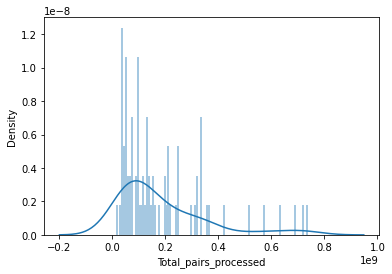

In [169]:
sns.distplot(all_stats.Total_pairs_processed, bins=100)

In [170]:
all_stats.sort_values("Valid_interaction_pairs")

,std_sample_name,Total_pairs_processed,Unmapped_pairs,Low_qual_pairs,Unique_paired_alignments,Multiple_pairs_alignments,Pairs_with_singleton,Low_qual_singleton,Unique_singleton_alignments,Multiple_singleton_alignments,Reported_pairs,Valid_interaction_pairs,Valid_interaction_pairs_FF,Valid_interaction_pairs_RR,Valid_interaction_pairs_RF,Valid_interaction_pairs_FR,Dangling_end_pairs,Religation_pairs,Self_Cycle_pairs,Single-end_pairs,Filtered_pairs,Dumped_pairs,valid_interaction,valid_interaction_rmdup,trans_interaction,cis_interaction,cis_shortRange,cis_longRange
73,mES_100k_cells.GSE101498.Mus_Musculus.H3K27ac.b2,57825242,56441425,11124,622,0,1372071,0,0,0,622,289,56,78,73,82,268,60,4,0,0,1,289,240,175,65,36,29
74,mES_500k_cells.GSE101498.Mus_Musculus.H3K27ac.b1,124627901,120685463,47675,3618,0,3891145,0,0,0,3618,326,75,73,41,137,2853,426,12,0,0,1,326,261,158,103,81,22
54,mES_500k_cells.GSE101498.Mus_Musculus.H3K27ac.b2,144063958,140170235,44989,3137,0,3845597,0,0,0,3137,336,45,75,62,154,2400,386,9,0,0,6,336,265,129,136,107,29
6,mES_50k_cells.GSE101498.Mus_Musculus.H3K27ac.b1,115461250,112936078,18081,1122,0,2505969,0,0,0,1122,513,127,112,118,156,481,110,16,0,0,2,513,408,307,101,45,56
41,mES_25m_cells.GSE101498.Mus_Musculus.H3K27ac.b1,321217020,313428160,63523,2552,0,7722785,0,0,0,2552,642,125,142,163,212,1579,315,14,0,0,2,642,572,355,217,155,62
65,mES_25m_cells.GSE101498.Mus_Musculus.H3K27ac.b2,333294302,323943717,67865,2284,0,9280436,0,0,0,2284,677,162,160,158,197,1331,238,35,0,0,3,677,600,419,181,105,76
14,Crypt.GSE148691.Mus_Musculus.H3K4me3.b1,96865408,93798844,28628,1427,0,3036509,0,0,0,1427,858,200,219,196,243,440,122,7,0,0,0,858,812,707,105,40,65
24,mES_50k_cells.GSE101498.Mus_Musculus.H3K27ac.b2,358002360,350948480,44506,2383,0,7006991,0,0,0,2383,1049,230,226,258,335,1008,302,20,0,0,4,1049,663,455,208,111,97
55,mES_100k_cells.GSE101498.Mus_Musculus.H3K27ac.b1,248686803,243226492,41820,2312,0,5416179,0,0,0,2312,1051,227,258,282,284,952,283,21,0,0,5,1051,853,641,212,110,102
75,Crypt-Hnf4DKO.GSE148691.Mus_Musculus.H3K4me3.b1,134608599,129677757,43918,2351,0,4884573,0,0,0,2351,1698,415,439,399,445,486,160,6,0,0,1,1698,1539,1376,163,54,109


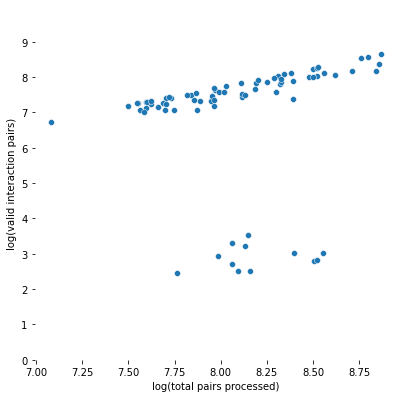

In [171]:
f, ax = plt.subplots(figsize=(6.5, 6.5))
sns.despine(f, left=True, bottom=True)
sns.scatterplot(x=np.log10(all_stats["Total_pairs_processed"]),
                y=np.log10(all_stats["Valid_interaction_pairs"]),
                ax=ax)
ax.set_xlabel('log(total pairs processed)')
ax.set_ylabel('log(valid interaction pairs)')
ax.set_ylim(0, 10)
ax.set_yticks(range(0, 10))

Text(0, 0.5, 'valid interaction pairs')

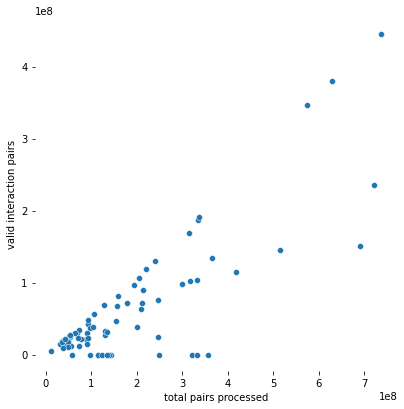

In [172]:
f, ax = plt.subplots(figsize=(6.5, 6.5))
sns.despine(f, left=True, bottom=True)
sns.scatterplot(x=all_stats["Total_pairs_processed"],
                y=all_stats["Valid_interaction_pairs"],
                ax=ax)
ax.set_xlabel('total pairs processed')
ax.set_ylabel('valid interaction pairs')
# ax.set_ylim(0, 10)
# ax.set_yticks(range(0, 10))

## Checking Kyra's Samples

In [176]:
ss = '/mnt/BioAdHoc/Groups/vd-ay/hichip-db-loop-calling/results/samplesheets/fastq/2022.04.09.16.57.fastq.samplesheet.with_header.tsv'

In [191]:
kf_data

,std_sample_name,gse_id,gsm_id,srr_id,organism,bio_rep,tech_rep,antibody_target,restriction_enzyme,sample_name
0,mES_25m_cells.GSE101498.Mus_Musculus.H3K27ac.b1,GSE101498,GSM2705031,SRR5831479,Mus_Musculus,1,1,H3K27ac,MboI,mES_25m_cells
1,mES_25m_cells.GSE101498.Mus_Musculus.H3K27ac.b1,GSE101498,GSM2705032,SRR5831480,Mus_Musculus,1,2,H3K27ac,MboI,mES_25m_cells
2,mES_25m_cells.GSE101498.Mus_Musculus.H3K27ac.b2,GSE101498,GSM2705033,SRR5831481,Mus_Musculus,2,1,H3K27ac,MboI,mES_25m_cells
3,mES_25m_cells.GSE101498.Mus_Musculus.H3K27ac.b2,GSE101498,GSM2705034,SRR5831482,Mus_Musculus,2,2,H3K27ac,MboI,mES_25m_cells
4,mES_500k_cells.GSE101498.Mus_Musculus.H3K27ac.b1,GSE101498,GSM2705035,SRR5831483,Mus_Musculus,1,1,H3K27ac,MboI,mES_500k_cells
5,mES_500k_cells.GSE101498.Mus_Musculus.H3K27ac.b2,GSE101498,GSM2705036,SRR5831484,Mus_Musculus,2,1,H3K27ac,MboI,mES_500k_cells
6,mES_100k_cells.GSE101498.Mus_Musculus.H3K27ac.b1,GSE101498,GSM2705037,SRR5831485,Mus_Musculus,1,1,H3K27ac,MboI,mES_100k_cells
7,mES_100k_cells.GSE101498.Mus_Musculus.H3K27ac.b2,GSE101498,GSM2705038,SRR5831486,Mus_Musculus,2,1,H3K27ac,MboI,mES_100k_cells
8,mES_50k_cells.GSE101498.Mus_Musculus.H3K27ac.b1,GSE101498,GSM2705039,SRR5831487,Mus_Musculus,1,1,H3K27ac,MboI,mES_50k_cells
9,mES_50k_cells.GSE101498.Mus_Musculus.H3K27ac.b2,GSE101498,GSM2705040,SRR5831488,Mus_Musculus,2,1,H3K27ac,MboI,mES_50k_cells


In [177]:
kf_data = pd.read_table(ss)

In [181]:
null_hic_samples = kf_data.iloc[[0,1,2,3,18,19]]

In [182]:
null_hic_samples

,std_sample_name,gse_id,gsm_id,srr_id,organism,bio_rep,tech_rep,antibody_target,restriction_enzyme,sample_name
0,mES_25m_cells.GSE101498.Mus_Musculus.H3K27ac.b1,GSE101498,GSM2705031,SRR5831479,Mus_Musculus,1,1,H3K27ac,MboI,mES_25m_cells
1,mES_25m_cells.GSE101498.Mus_Musculus.H3K27ac.b1,GSE101498,GSM2705032,SRR5831480,Mus_Musculus,1,2,H3K27ac,MboI,mES_25m_cells
2,mES_25m_cells.GSE101498.Mus_Musculus.H3K27ac.b2,GSE101498,GSM2705033,SRR5831481,Mus_Musculus,2,1,H3K27ac,MboI,mES_25m_cells
3,mES_25m_cells.GSE101498.Mus_Musculus.H3K27ac.b2,GSE101498,GSM2705034,SRR5831482,Mus_Musculus,2,2,H3K27ac,MboI,mES_25m_cells
18,Naive_Tcells.GSE101498.Homo_Sapiens.H3K27ac.b2,GSE101498,GSM2705049,SRR5831497,Homo_Sapiens,2,1,H3K27ac,MboI,Naive_Tcells
19,Naive_Tcells.GSE101498.Homo_Sapiens.H3K27ac.b2,GSE101498,GSM2705050,SRR5831498,Homo_Sapiens,2,2,H3K27ac,MboI,Naive_Tcells


In [183]:
sparse_samples = kf_data.iloc[range(5,19)]

In [184]:
sparse_samples

,std_sample_name,gse_id,gsm_id,srr_id,organism,bio_rep,tech_rep,antibody_target,restriction_enzyme,sample_name
5,mES_500k_cells.GSE101498.Mus_Musculus.H3K27ac.b2,GSE101498,GSM2705036,SRR5831484,Mus_Musculus,2,1,H3K27ac,MboI,mES_500k_cells
6,mES_100k_cells.GSE101498.Mus_Musculus.H3K27ac.b1,GSE101498,GSM2705037,SRR5831485,Mus_Musculus,1,1,H3K27ac,MboI,mES_100k_cells
7,mES_100k_cells.GSE101498.Mus_Musculus.H3K27ac.b2,GSE101498,GSM2705038,SRR5831486,Mus_Musculus,2,1,H3K27ac,MboI,mES_100k_cells
8,mES_50k_cells.GSE101498.Mus_Musculus.H3K27ac.b1,GSE101498,GSM2705039,SRR5831487,Mus_Musculus,1,1,H3K27ac,MboI,mES_50k_cells
9,mES_50k_cells.GSE101498.Mus_Musculus.H3K27ac.b2,GSE101498,GSM2705040,SRR5831488,Mus_Musculus,2,1,H3K27ac,MboI,mES_50k_cells
10,GM.GSE101498.Homo_Sapiens.H3K27ac.b1,GSE101498,GSM2705041,SRR5831489,Homo_Sapiens,1,1,H3K27ac,MboI,GM
11,GM.GSE101498.Homo_Sapiens.H3K27ac.b2,GSE101498,GSM2705042,SRR5831490,Homo_Sapiens,2,1,H3K27ac,MboI,GM
12,K562.GSE101498.Homo_Sapiens.H3K27ac.b1,GSE101498,GSM2705043,SRR5831491,Homo_Sapiens,1,1,H3K27ac,MboI,K562
13,K562.GSE101498.Homo_Sapiens.H3K27ac.b2,GSE101498,GSM2705044,SRR5831492,Homo_Sapiens,2,1,H3K27ac,MboI,K562
14,K562.GSE101498.Homo_Sapiens.H3K27ac.b3,GSE101498,GSM2705045,SRR5831493,Homo_Sapiens,3,1,H3K27ac,MboI,K562


In [187]:
all_stats.loc[all_stats.std_sample_name.isin(null_hic_samples.std_sample_name)]

,std_sample_name,Total_pairs_processed,Unmapped_pairs,Low_qual_pairs,Unique_paired_alignments,Multiple_pairs_alignments,Pairs_with_singleton,Low_qual_singleton,Unique_singleton_alignments,Multiple_singleton_alignments,Reported_pairs,Valid_interaction_pairs,Valid_interaction_pairs_FF,Valid_interaction_pairs_RR,Valid_interaction_pairs_RF,Valid_interaction_pairs_FR,Dangling_end_pairs,Religation_pairs,Self_Cycle_pairs,Single-end_pairs,Filtered_pairs,Dumped_pairs,valid_interaction,valid_interaction_rmdup,trans_interaction,cis_interaction,cis_shortRange,cis_longRange
41,mES_25m_cells.GSE101498.Mus_Musculus.H3K27ac.b1,321217020,313428160,63523,2552,0,7722785,0,0,0,2552,642,125,142,163,212,1579,315,14,0,0,2,642,572,355,217,155,62
65,mES_25m_cells.GSE101498.Mus_Musculus.H3K27ac.b2,333294302,323943717,67865,2284,0,9280436,0,0,0,2284,677,162,160,158,197,1331,238,35,0,0,3,677,600,419,181,105,76
71,Naive_Tcells.GSE101498.Homo_Sapiens.H3K27ac.b2,193547252,1851691,57780399,122861482,0,11053680,0,0,0,122861482,96984223,23712223,23787147,24231810,25253043,16625613,8292545,955835,0,0,3266,96984223,87422976,22882644,64540332,21771309,42769023


In [189]:
null_hic_samples.std_sample_name.tolist()

['mES_25m_cells.GSE101498.Mus_Musculus.H3K27ac.b1',
 'mES_25m_cells.GSE101498.Mus_Musculus.H3K27ac.b1',
 'mES_25m_cells.GSE101498.Mus_Musculus.H3K27ac.b2',
 'mES_25m_cells.GSE101498.Mus_Musculus.H3K27ac.b2',
 'Naive_Tcells.GSE101498.Homo_Sapiens.H3K27ac.b2',
 'Naive_Tcells.GSE101498.Homo_Sapiens.H3K27ac.b2']

In [190]:
all_stats

,std_sample_name,Total_pairs_processed,Unmapped_pairs,Low_qual_pairs,Unique_paired_alignments,Multiple_pairs_alignments,Pairs_with_singleton,Low_qual_singleton,Unique_singleton_alignments,Multiple_singleton_alignments,Reported_pairs,Valid_interaction_pairs,Valid_interaction_pairs_FF,Valid_interaction_pairs_RR,Valid_interaction_pairs_RF,Valid_interaction_pairs_FR,Dangling_end_pairs,Religation_pairs,Self_Cycle_pairs,Single-end_pairs,Filtered_pairs,Dumped_pairs,valid_interaction,valid_interaction_rmdup,trans_interaction,cis_interaction,cis_shortRange,cis_longRange
0,HT55.GSE147854.Homo_Sapiens.H3K27ac.b1,88687267,7356114,22188261,54486749,0,4656143,0,0,0,54486749,21215608,4641464,4644784,5310214,6619146,21763210,10568582,935997,0,0,3352,21215608,19989419,2394823,17594596,8878873,8715723
1,Ramos.GSE179755.Homo_Sapiens.H3K27ac.b1,42179029,1059374,13116390,25579060,0,2424205,0,0,0,25579060,17915546,4426978,4435366,4423709,4629493,6327668,1275182,59864,0,0,800,17915546,16708096,3443181,13264915,2891308,10373607
2,H9-siNIPBL-HS.GSE105028.Homo_Sapiens.CTCF.b1,56100419,1082647,19409942,27220820,0,8387010,0,0,0,27220820,12093604,2767517,2758002,2549571,4018514,10568412,4009473,14968,0,0,534363,12093604,4305620,674711,3630909,1709156,1921753
3,Th17.GSE101498.Homo_Sapiens.H3K27ac.b1,92821305,1549281,26370704,58668864,0,6232456,0,0,0,58668864,42525103,10242624,10269169,10872246,11141064,10722367,4554771,865018,0,0,1605,42525103,38423564,10622817,27800747,9805885,17994862
4,Villus-Hnf4DKO.GSE148691.Mus_Musculus.H3K4me3.b1,114611937,110087000,46997,2472,0,4475468,0,0,0,2472,1985,443,546,493,503,322,141,15,0,0,9,1985,1903,1691,212,78,134
5,lgs102943.GSE116193.Homo_Sapiens.H3K27ac.b1,35509764,527965,11220979,21021778,0,2739042,0,0,0,21021778,18720816,4644223,4643696,4651519,4781378,1520313,674016,106150,0,0,483,18720816,18151051,5355846,12795205,2588131,10207074
6,mES_50k_cells.GSE101498.Mus_Musculus.H3K27ac.b1,115461250,112936078,18081,1122,0,2505969,0,0,0,1122,513,127,112,118,156,481,110,16,0,0,2,513,408,307,101,45,56
7,GM.GSE101498.Homo_Sapiens.H3K27ac.b1,332279257,5835943,101429643,149165430,0,75848241,0,0,0,149165430,104375182,25037436,25102376,26773673,27461697,24314320,17224883,3241909,0,0,9136,104375182,91034016,9671220,81362796,38290781,43072015
8,JSC.GSE136090.Homo_Sapiens.H3K27ac.b1,36734111,899065,11431479,20980636,0,3422931,0,0,0,20980636,11867302,2871373,2880529,2904294,3211106,7051342,1982041,78793,0,0,1158,11867302,11451314,2324068,9127246,2807742,6319504
9,H9-HS.GSE105028.Homo_Sapiens.H3K4me1.b1,208844380,5356707,68243172,102859934,0,32384567,0,0,0,102859934,62917771,14319356,14310927,12928264,21359224,19841400,15573688,100715,0,0,4426360,62917771,23312595,2221467,21091128,10735119,10356009


In [192]:
hic_ss = '/mnt/BioAdHoc/Groups/vd-ay/hichip-db-loop-calling/results/samplesheets/hicpro/2022.04.09.16.57.hicpro.samplesheet.with_header.tsv'

In [193]:
hic_ss_df = pd.read_table(hic_ss)

In [194]:
hic_ss_df

,std_sample_name,gse_id,organism,bio_rep,antibody_target,restriction_enzyme,sample_name
0,mES_25m_cells.GSE101498.Mus_Musculus.H3K27ac.b1,GSE101498,Mus_Musculus,1,H3K27ac,MboI,mES_25m_cells
1,mES_25m_cells.GSE101498.Mus_Musculus.H3K27ac.b2,GSE101498,Mus_Musculus,2,H3K27ac,MboI,mES_25m_cells
2,mES_500k_cells.GSE101498.Mus_Musculus.H3K27ac.b1,GSE101498,Mus_Musculus,1,H3K27ac,MboI,mES_500k_cells
3,mES_500k_cells.GSE101498.Mus_Musculus.H3K27ac.b2,GSE101498,Mus_Musculus,2,H3K27ac,MboI,mES_500k_cells
4,mES_100k_cells.GSE101498.Mus_Musculus.H3K27ac.b1,GSE101498,Mus_Musculus,1,H3K27ac,MboI,mES_100k_cells
5,mES_100k_cells.GSE101498.Mus_Musculus.H3K27ac.b2,GSE101498,Mus_Musculus,2,H3K27ac,MboI,mES_100k_cells
6,mES_50k_cells.GSE101498.Mus_Musculus.H3K27ac.b1,GSE101498,Mus_Musculus,1,H3K27ac,MboI,mES_50k_cells
7,mES_50k_cells.GSE101498.Mus_Musculus.H3K27ac.b2,GSE101498,Mus_Musculus,2,H3K27ac,MboI,mES_50k_cells
8,GM.GSE101498.Homo_Sapiens.H3K27ac.b1,GSE101498,Homo_Sapiens,1,H3K27ac,MboI,GM
9,GM.GSE101498.Homo_Sapiens.H3K27ac.b2,GSE101498,Homo_Sapiens,2,H3K27ac,MboI,GM
